In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("drive/My Drive")
os.chdir("BBM418/Assignment3")

<h1 align="center">Hacettepe University<br>Department of Computer Science</h1> 
<h2 align="center">BBM 418 - Computer Vision Laboratory<br>2022 Spring</h2>
<h3 align="center">Assignment 3</h3>
<h3 align="left">Name    :    Murat Çelik</h3>
<h3 align="left">ID      :    21827263</h3>
<h4 align="right">Due on April 27, 2022</h4>


## Table of Contents
- [1 - Introduction](#1)
- [2 - DataSet](#2)
- [3 - Part 1 Modeling and Training a CNN classifier from Scratch](#3)
    - [3.1 - Convolutional Neural Networks Architecture](#3.1)
        - [3.1.1 - Train and Test Functions](#3.1.1)
        - [3.1.2 - CNN Information](#3.1.2)      
    - [3.2 - Residual Connections](#3.2)
        - [3.2.1 - Model Have Residual Connections](#3.2.1)
        - [3.2.2 - Model Have NOT Residual Connections](#3.2.2)
        - [3.2.3 - Comparision Residual Connections](#3.2.3)
    - [3.3 - Learning Rate Comparision](#3.3)
        - [3.3.1 - Comparision Learning Rate](#3.3.1)
    - [3.4 - Batch Size Comparision](#3.4)
        - [3.4.1 - Comparision Batch Size](#3.4.1)
    - [3.5 - Dropout Best Model](#3.5)
        - [3.5.1 - Comparision Dropout Model](#3.5.1)
    - [3.6 - Best Model Analysis](#3.6)
- [4 - Part 2 Transfer Learning with CNNs](#4)
- [5 - Conclusion](#5)
- [6 - References](#6)

# 1. Introduction <a name='1'></a>
This assignment includes analysis on Convolutional Neural Networks. A model is created from scratch to understand the CNN architecture. A CNN-based transfer learning is done. The results are analyzed. In this whole process, the Pytorch library was used and the improvements were made on Colab.

In [20]:
from torchvision import transforms 
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import models, transforms

from torchvision.utils import make_grid
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import json 
from tqdm.notebook import tqdm, trange
import time

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 2. DataSet <a name='2'></a>

There are 15 categories; bean, bitter_gourd, bottle_gourd,
brinjal, broccoli, cabbage, capsicum, carrot, cauliflower, cucumber, papaya, potato, pumpkin, radish and tomato. The training set includes 3000 images, the validation set includes 750 images, and the test set includes 750 images. There are a total of 4500 images, 300 from each class. In all distributions, in accordance with the stratify rule, there are equal numbers of each class in each section.


In [23]:
def get_data(batch_size = 64):
  DATA_PATH = 'data' 
  INPUT_SIZE = 224
  BATCH_SIZE = batch_size
  normalize = transforms.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
  transform = transforms.Compose([
      transforms.RandomResizedCrop(INPUT_SIZE),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      normalize
  ])
  dataset = ImageFolder(DATA_PATH, transform=transform)
  # split data indexes with train_test_split function
  train_valid_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size=(750/4500), stratify=dataset.targets, random_state=42)
  train_indices, valid_indices = train_test_split(list(range(len(train_valid_indices))), test_size=(750/3750), stratify=[dataset.targets[x] for x in train_valid_indices], random_state=42)

  train_split = Subset(dataset, train_indices)
  test_split = Subset(dataset, test_indices)
  valid_split = Subset(dataset, valid_indices)

  train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=True)
  valid_loader = DataLoader(valid_split, batch_size=BATCH_SIZE, shuffle=True)
  classes = dataset.classes
  return train_loader, test_loader, valid_loader, classes

In [24]:
# Each batch should contain 64 images.
BATCH_SIZE = 64
train_loader, test_loader, valid_loader, classes = get_data(batch_size=BATCH_SIZE)

In [25]:
# Evidence of every class in each batch.
label_in_batch = list()
for x,y in test_loader:
  list_int_value = y.tolist()
  for z in list_int_value:
    label_in_batch.append(int(z))
set(label_in_batch)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


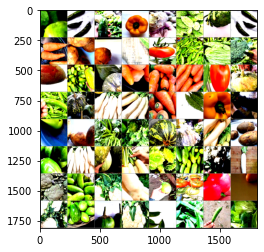

First 8 label :
PapayaBean CucumberCapsicumPotatoBitter_GourdBroccoliBean 


In [26]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(test_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print("First 8 label :")
print(''.join(f'{classes[labels[j]]:5s}' for j in range(8)))

# 3. Part 1 Modeling and Training a CNN classifier from Scratch <a name='3'></a>

## 3.1 - Convolutional Neural Networks Architecture <a name='3.1'></a>

### 3.1.1 - Train and Test Functions <a name='3.1.1'></a>

In [ ]:
# This cell should not be run

model = Neural_Network_model_()   # An object will be created from the created model class
model = model.to(device=device) 
criterion = nn.CrossEntropyLoss() # Loss function created
EPOCH = 50                        # Epoch number determined
LEARNING_RATE = 0.0005            # Learning Rate determined
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE) # Optimization function created


# Necessary functions to follow the process in the train phase
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Functions prepared for train and evaluation
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device=device) 
        y = y.to(device=device) 

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device=device) 
            y = y.to(device=device) 

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# It records the loss and accuracy values in the whole process.
train_losses = list()
valid_losses = list()
train_accuracys = list()
valid_accuracys = list()
best_valid_loss = float('inf')
data_model = dict()

for epoch in trange(EPOCH, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracys.append(train_acc)
    valid_accuracys.append(valid_acc)
    # The best score model saves.
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "base"+str(LEARNING_RATE)+"_"+str(EPOCH)+"_"+"model.pt") #SAVES THE TRAINED MODEL
        data_model["train_accuracys"] = train_accuracys
        data_model["valid_accuracys"] = valid_accuracys
        data_model["train_losses"] = train_losses
        data_model["valid_losses"] = valid_losses
        with open("base"+str(LEARNING_RATE)+"_"+str(EPOCH)+"_"+'model.json', "w") as outfile:
            json.dump(data_model, outfile)
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Test function has been prepared in accordance with all models. Steps have been taken to clean code.

In [27]:
def test_data_on_model(model, test_loader):
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  correct = 0
  total = 0

  with torch.no_grad():
      for (x, y) in tqdm(test_loader, desc="Testing", leave=False):
          images = x.to(device)
          labels = y.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predictions == labels).sum().item()
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  print(f'Accuracy of the network on the 750 test images: {100 * correct // total} %')
  print()

  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

All models were recorded after the training phase. The following function is used to read the recorded files.

In [28]:
def read_info_model(model, model_name, dropout_bool = False):
  MODEL_DIR = "model_info"
  f = open(MODEL_DIR + "/" + model_name +".json")
  data = json.load(f)
  f.close()
  model.load_state_dict(torch.load(MODEL_DIR + "/" + model_name +".pt"))
  model.eval()
  return model, data  

### 3.1.2 - CNN Information <a name='3.1.2'></a>

![CNN Architecture](https://drive.google.com/uc?export=view&id=1ZVXKyT9HFHiAE9az9R4U7-2wSyEdKnnV)

* The operations in which we select the maximum value in every 4 pixels and thus reduce the input size by half are called ***(max) pooling***.

* The process of applying a filter that results in an activation function to the entire image is called ***convolution***.

* The purpose of ***CrossEntropyLoss*** is to take the output probabilities (P) and measure the distance from the truth values.

* The ***Adam optimization*** algorithm is an extension of stochastic gradient descent popularized in deep learning applications.

## 3.2 - Residual Connections <a name='3.2'></a>

Residual Connections are structures formed by adding some data to the neural network via an alternative route. In the model created below, a residual connection is created between the 3rd and 4th and 4th and 5th type layers. Looking at the results, residual networks provided an additional 5% success.

In [29]:
class Net_Residual(nn.Module):
    def __init__(self, residual = False):
        super().__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.residual = residual

        self.fc1 = nn.Linear(25088 * 4, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 15)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        if self.residual:
          residual_one = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        if self.residual:
          residual_two = x + residual_one
          x = x + residual_one
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        if self.residual:
          x = x + residual_two
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 3.2.1 - Model Have Residual Connections <a name='3.2.1'></a>



In [30]:
model = Net_Residual(residual=True).to(device=device)
model_lr0005_residual, data_lr0005_residual = read_info_model(model,"lr0005epoch50_residualmodel" )
test_data_on_model(model_lr0005_residual, test_loader)

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 750 test images: 79 %

Accuracy for class: Bean  is 86.0 %
Accuracy for class: Bitter_Gourd is 90.0 %
Accuracy for class: Bottle_Gourd is 92.0 %
Accuracy for class: Brinjal is 84.0 %
Accuracy for class: Broccoli is 96.0 %
Accuracy for class: Cabbage is 94.0 %
Accuracy for class: Capsicum is 96.0 %
Accuracy for class: Carrot is 96.0 %
Accuracy for class: Cauliflower is 90.0 %
Accuracy for class: Cucumber is 86.0 %
Accuracy for class: Papaya is 86.0 %
Accuracy for class: Potato is 96.0 %
Accuracy for class: Pumpkin is 96.0 %
Accuracy for class: Radish is 0.0 %
Accuracy for class: Tomato is 0.0 %


### 3.2.2 - Model Have NOT Residual Connections <a name='3.2.2'></a>


In [31]:
model = Net_Residual(residual=False).to(device=device)
model_lr0005_without_residual, data_lr0005_without_residual = read_info_model(model,"base_vgg16_0.0005_50_withoutresidualmodel" )
test_data_on_model(model_lr0005_without_residual, test_loader)

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 750 test images: 75 %

Accuracy for class: Bean  is 74.0 %
Accuracy for class: Bitter_Gourd is 86.0 %
Accuracy for class: Bottle_Gourd is 94.0 %
Accuracy for class: Brinjal is 86.0 %
Accuracy for class: Broccoli is 84.0 %
Accuracy for class: Cabbage is 86.0 %
Accuracy for class: Capsicum is 96.0 %
Accuracy for class: Carrot is 90.0 %
Accuracy for class: Cauliflower is 90.0 %
Accuracy for class: Cucumber is 84.0 %
Accuracy for class: Papaya is 88.0 %
Accuracy for class: Potato is 94.0 %
Accuracy for class: Pumpkin is 84.0 %
Accuracy for class: Radish is 0.0 %
Accuracy for class: Tomato is 0.0 %


### 3.2.3 - Comparision Residual Connections <a name='3.2.3'></a>

Comparing the above results, an accuracy value of more than 4% was obtained by adding the residual network. Although these values do not pose a problem for the algorithm, it has been a recommended method to be used by improving the results.

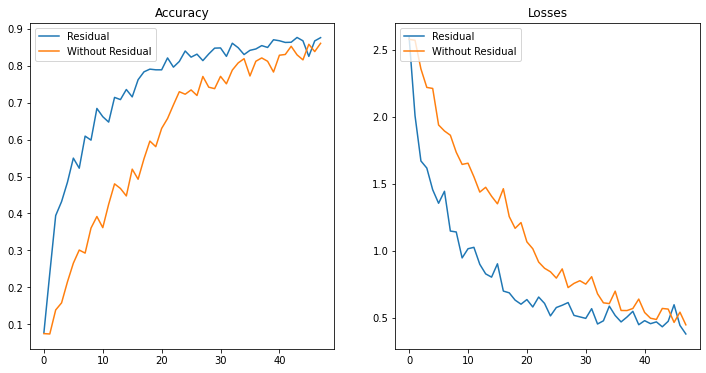

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))


x = range(len(data_lr0005_without_residual["valid_accuracys"]))
y1 = data_lr0005_residual["valid_accuracys"][:len(data_lr0005_without_residual["valid_accuracys"])]
y2 = data_lr0005_without_residual["valid_accuracys"][:len(data_lr0005_without_residual["valid_accuracys"])]

ax[0].plot(x, y1, label="Residual")
ax[0].plot(x, y2, label="Without Residual")
ax[0].legend(loc="upper left")
ax[0].set_title("Accuracy")

x = range(len(data_lr0005_without_residual["valid_losses"]))
y1 = data_lr0005_residual["valid_losses"][:len(data_lr0005_without_residual["valid_losses"])]
y2 = data_lr0005_without_residual["valid_losses"][:len(data_lr0005_without_residual["valid_losses"])]

ax[1].plot(x, y1, label="Residual")
ax[1].plot(x, y2, label="Without Residual")
ax[1].legend(loc="upper left")
ax[1].set_title("Losses")

plt.show()

## 3.3 - Learning Rate Comparision <a name='3.3'></a>
Deep learning neural networks are trained using a stochastic gradient descent optimization algorithm. Adam optimization is used in these algorithms. The learning rate is a hyperparameter that controls how much the model is updated in response to the estimated error each time the model weights are updated. Too large of this value makes it difficult to reach the minimum error point. If this value is too small,reach the minimum error point in too many steps. This value should be chosen as an average value.

In this algorithm, 3 different learning rate values are used: 0.001, 0.0005, 0.00005

In [33]:

class Net_vgg16(nn.Module):
    def __init__(self, dropout_bool = False):
        super().__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_bool = dropout_bool
        self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(25088 , 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 15)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        if self.dropout_bool:
          x = self.dropout(x)
        x = F.relu(self.fc2(x))
        if self.dropout_bool:
          x = self.dropout(x)
        x = self.fc3(x)
        return x

#### Learning Rate = 0.001

In [34]:
model = Net_vgg16().to(device=device)
model_lr001_vgg16, data_lr001_vgg16 = read_info_model(model,"lr001epoch50_vgg16model" )
test_data_on_model(model_lr001_vgg16, test_loader)

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 750 test images: 71 %

Accuracy for class: Bean  is 70.0 %
Accuracy for class: Bitter_Gourd is 90.0 %
Accuracy for class: Bottle_Gourd is 86.0 %
Accuracy for class: Brinjal is 78.0 %
Accuracy for class: Broccoli is 84.0 %
Accuracy for class: Cabbage is 90.0 %
Accuracy for class: Capsicum is 94.0 %
Accuracy for class: Carrot is 90.0 %
Accuracy for class: Cauliflower is 78.0 %
Accuracy for class: Cucumber is 68.0 %
Accuracy for class: Papaya is 96.0 %
Accuracy for class: Potato is 88.0 %
Accuracy for class: Pumpkin is 56.0 %
Accuracy for class: Radish is 0.0 %
Accuracy for class: Tomato is 0.0 %


#### Learning Rate = 0.0005



In [35]:
model = Net_vgg16().to(device=device)
model_lr0005_vgg16, data_lr0005_vgg16 = read_info_model(model,"lr0005epoch50_vgg16model" )
test_data_on_model(model_lr0005_vgg16, test_loader)

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 750 test images: 75 %

Accuracy for class: Bean  is 82.0 %
Accuracy for class: Bitter_Gourd is 88.0 %
Accuracy for class: Bottle_Gourd is 82.0 %
Accuracy for class: Brinjal is 88.0 %
Accuracy for class: Broccoli is 90.0 %
Accuracy for class: Cabbage is 88.0 %
Accuracy for class: Capsicum is 98.0 %
Accuracy for class: Carrot is 96.0 %
Accuracy for class: Cauliflower is 86.0 %
Accuracy for class: Cucumber is 86.0 %
Accuracy for class: Papaya is 84.0 %
Accuracy for class: Potato is 94.0 %
Accuracy for class: Pumpkin is 72.0 %
Accuracy for class: Radish is 0.0 %
Accuracy for class: Tomato is 0.0 %


#### Learning Rate = 0.00005

In [36]:
model = Net_vgg16().to(device=device)
model_lr00005_vgg16, data_lr00005_vgg16 = read_info_model(model,"lr00005epoch50_vgg16model" )
test_data_on_model(model_lr00005_vgg16, test_loader)

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 750 test images: 73 %

Accuracy for class: Bean  is 84.0 %
Accuracy for class: Bitter_Gourd is 86.0 %
Accuracy for class: Bottle_Gourd is 82.0 %
Accuracy for class: Brinjal is 72.0 %
Accuracy for class: Broccoli is 92.0 %
Accuracy for class: Cabbage is 98.0 %
Accuracy for class: Capsicum is 88.0 %
Accuracy for class: Carrot is 92.0 %
Accuracy for class: Cauliflower is 80.0 %
Accuracy for class: Cucumber is 70.0 %
Accuracy for class: Papaya is 90.0 %
Accuracy for class: Potato is 96.0 %
Accuracy for class: Pumpkin is 74.0 %
Accuracy for class: Radish is 0.0 %
Accuracy for class: Tomato is 0.0 %


### 3.3.1 - Comparision Learning Rate <a name='3.3.1'></a>

A value of 0.0005 is considered the best option for the model. Since 0.001 is too large, it is difficult to reach the minimum. Since the value of 0.00005 is small for the model, it may reach the minimum value in more steps.

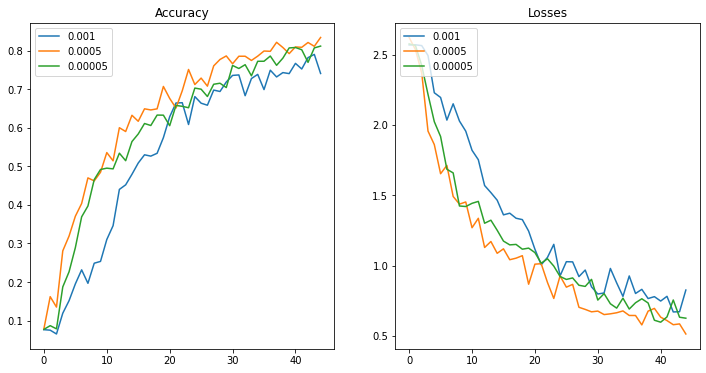

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))


x = range(len(data_lr0005_vgg16["valid_accuracys"]))
y1 = data_lr001_vgg16["valid_accuracys"][:len(data_lr0005_vgg16["valid_accuracys"])]
y2 = data_lr0005_vgg16["valid_accuracys"][:len(data_lr0005_vgg16["valid_accuracys"])]
y3 = data_lr00005_vgg16["valid_accuracys"][:len(data_lr0005_vgg16["valid_accuracys"])]

ax[0].plot(x, y1, label="0.001")
ax[0].plot(x, y2, label="0.0005")
ax[0].plot(x, y3, label="0.00005")
ax[0].legend(loc="upper left")
ax[0].set_title("Accuracy")

x = range(len(data_lr0005_vgg16["valid_losses"]))
y1 = data_lr001_vgg16["valid_losses"][:len(data_lr0005_vgg16["valid_losses"])]
y2 = data_lr0005_vgg16["valid_losses"][:len(data_lr0005_vgg16["valid_losses"])]
y3 = data_lr00005_vgg16["valid_losses"][:len(data_lr0005_vgg16["valid_losses"])]

ax[1].plot(x, y1, label="0.001")
ax[1].plot(x, y2, label="0.0005")
ax[1].plot(x, y3, label="0.00005")
ax[1].legend(loc="upper left")
ax[1].set_title("Losses")

plt.show()

## 3.4 - Batch Size <a name='3.4'></a>

There are 3000 data in our train data and 750 data in our validation data. I use this data in smaller sets to train the model. These sets are called batches. In this algorithm, two batch size values, 64 and 128, were determined.


In [38]:
train_loader_128, test_loader_128, valid_loader_128, classes = get_data(batch_size=128)
model = Net_vgg16().to(device=device)
model_lr0005_vgg16_batch128, data_lr0005_vgg16_batch128 = read_info_model(model,"lr0005epoch50batch128_vggmodel" )
test_data_on_model(model_lr0005_vgg16_batch128, test_loader_128)

Testing:   0%|          | 0/6 [00:00<?, ?it/s]

Accuracy of the network on the 750 test images: 72 %

Accuracy for class: Bean  is 86.0 %
Accuracy for class: Bitter_Gourd is 62.0 %
Accuracy for class: Bottle_Gourd is 86.0 %
Accuracy for class: Brinjal is 70.0 %
Accuracy for class: Broccoli is 84.0 %
Accuracy for class: Cabbage is 98.0 %
Accuracy for class: Capsicum is 90.0 %
Accuracy for class: Carrot is 92.0 %
Accuracy for class: Cauliflower is 82.0 %
Accuracy for class: Cucumber is 76.0 %
Accuracy for class: Papaya is 90.0 %
Accuracy for class: Potato is 94.0 %
Accuracy for class: Pumpkin is 76.0 %
Accuracy for class: Radish is 0.0 %
Accuracy for class: Tomato is 0.0 %


### 3.4.1 - Comparision Batch Size <a name='3.4.1'></a>

As a result of the analysis, it is observed that the value of 64 is more successful than the value of 128. A smaller value of 64 may give better results for a while, but getting smaller may have a negative effect on this model.

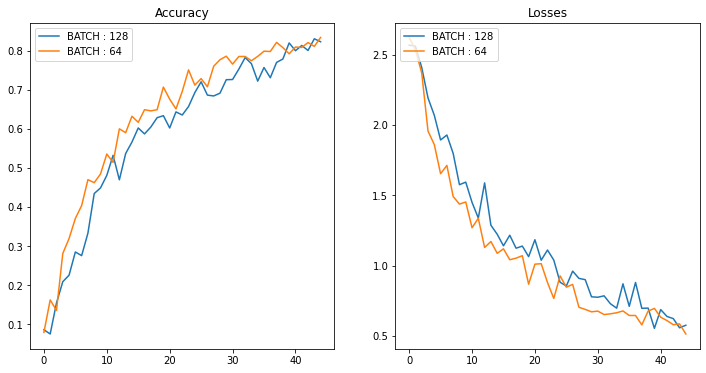

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))


x = range(len(data_lr0005_vgg16["valid_accuracys"]))
y1 = data_lr0005_vgg16_batch128["valid_accuracys"][:len(data_lr0005_vgg16["valid_accuracys"])]
y2 = data_lr0005_vgg16["valid_accuracys"][:len(data_lr0005_vgg16["valid_accuracys"])]

ax[0].plot(x, y1, label="BATCH : 128")
ax[0].plot(x, y2, label="BATCH : 64")
ax[0].legend(loc="upper left")
ax[0].set_title("Accuracy")

x = range(len(data_lr0005_vgg16["valid_losses"]))
y1 = data_lr0005_vgg16_batch128["valid_losses"][:len(data_lr0005_vgg16["valid_losses"])]
y2 = data_lr0005_vgg16["valid_losses"][:len(data_lr0005_vgg16["valid_losses"])]

ax[1].plot(x, y1, label="BATCH : 128")
ax[1].plot(x, y2, label="BATCH : 64")
ax[1].legend(loc="upper left")
ax[1].set_title("Losses")

plt.show()

## 3.5 - Dropout Best Model <a name='3.5'></a>

It is assumed that removing some links within the network will improve training performance and prevent overfit. This process is called ***dropout***. The dropout layer is given a ratio greater than 0 and less than 1. This value is the probability value.

In [40]:
model = Net_vgg16(dropout_bool=True).to(device=device)
model_lr0005_vgg16_dropout, data_lr0005_vgg16_dropout = read_info_model(model,"lr0005epoch50_vgg16dropoutmodel" )
test_data_on_model(model_lr0005_vgg16_dropout, test_loader)

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 750 test images: 69 %

Accuracy for class: Bean  is 54.0 %
Accuracy for class: Bitter_Gourd is 80.0 %
Accuracy for class: Bottle_Gourd is 86.0 %
Accuracy for class: Brinjal is 72.0 %
Accuracy for class: Broccoli is 84.0 %
Accuracy for class: Cabbage is 82.0 %
Accuracy for class: Capsicum is 94.0 %
Accuracy for class: Carrot is 88.0 %
Accuracy for class: Cauliflower is 76.0 %
Accuracy for class: Cucumber is 72.0 %
Accuracy for class: Papaya is 88.0 %
Accuracy for class: Potato is 94.0 %
Accuracy for class: Pumpkin is 72.0 %
Accuracy for class: Radish is 0.0 %
Accuracy for class: Tomato is 0.0 %


### 3.5.1 - Comparision Dropout Model <a name='3.5.1'></a>

Under normal circumstances, it is said that the dropout function will increase success. Since our model did not have an overfit problem and the train and validation performances were similar, this value had a negative effect on our model. If we develop our model further, the overfit problem will arise, and one of the best options to fix this would be the dropout technique.

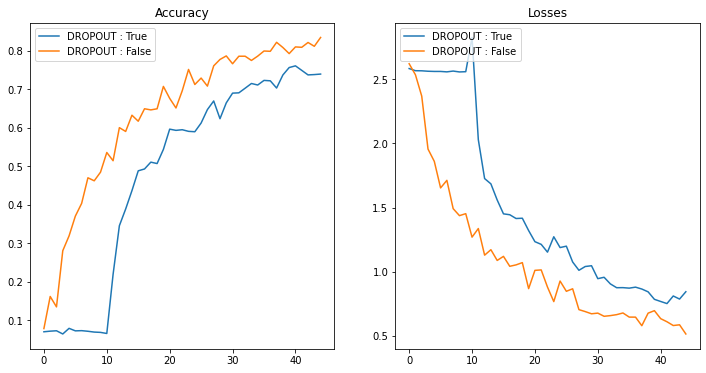

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))


x = range(len(data_lr0005_vgg16["valid_accuracys"]))
y1 = data_lr0005_vgg16_dropout["valid_accuracys"][:len(data_lr0005_vgg16["valid_accuracys"])]
y2 = data_lr0005_vgg16["valid_accuracys"][:len(data_lr0005_vgg16["valid_accuracys"])]

ax[0].plot(x, y1, label="DROPOUT : True")
ax[0].plot(x, y2, label="DROPOUT : False")
ax[0].legend(loc="upper left")
ax[0].set_title("Accuracy")

x = range(len(data_lr0005_vgg16["valid_losses"]))
y1 = data_lr0005_vgg16_dropout["valid_losses"][:len(data_lr0005_vgg16["valid_losses"])]
y2 = data_lr0005_vgg16["valid_losses"][:len(data_lr0005_vgg16["valid_losses"])]

ax[1].plot(x, y1, label="DROPOUT : True")
ax[1].plot(x, y2, label="DROPOUT : False")
ax[1].legend(loc="upper left")
ax[1].set_title("Losses")

plt.show()

## 3.6 - Best Model Analysis <a name='3.6'></a>

- The best option for the learning rate value was 0.0005. The best value for the batch size value is 64. The value of 50 was used as the epoch number. RELU activation function is used in the models because of its fastness and high performance, solving the vanishing gradient problem.

- In all these analyses, the above hyperparameters were chosen as the main model. Dropout technique had a negative effect for this epoch number. Residual connections, on the other hand, increase success.

- In the matrix below, it is observed that the classes "Tomato, Radish, Bean" are not predicted correctly enough. In order to develop these classes, it is necessary to increase the epoch value and optimize the hyperparameters. For values, residual links can be added to the algorithm and the model can be developed.


In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

correct = 0
total = 0

y_pred = list()
y_test = list()

with torch.no_grad():
    for (x, y) in tqdm(test_loader, desc="Testing", leave=False):
        images = x.to(device)
        labels = y.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        y_pred = y_pred + predictions.tolist()
        y_test = y_test + labels.tolist()

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

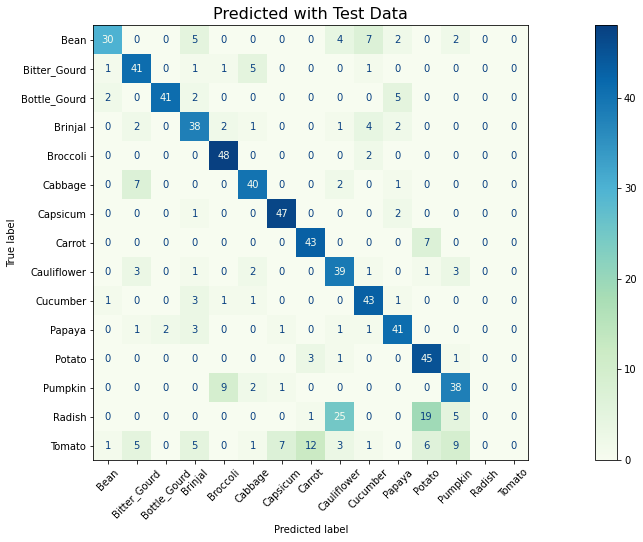

In [43]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax1 = plt.subplots(1, 1, figsize = (24, 8))
disp.plot(ax=ax1, cmap='GnBu')
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_title('Predicted with Test Data', fontsize=16)

plt.show()

In the chart below, the results of the train and validation data are given for the best model.

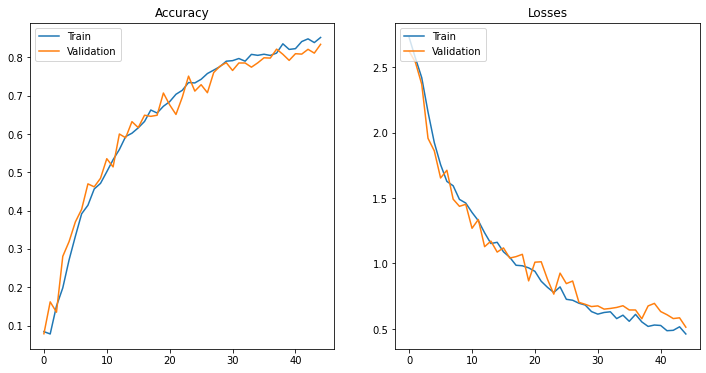

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))


x = range(len(data_lr0005_vgg16["valid_accuracys"]))
y1 = data_lr0005_vgg16["train_accuracys"][:len(data_lr0005_vgg16["valid_accuracys"])]
y2 = data_lr0005_vgg16["valid_accuracys"][:len(data_lr0005_vgg16["valid_accuracys"])]

ax[0].plot(x, y1, label="Train")
ax[0].plot(x, y2, label="Validation")
ax[0].legend(loc="upper left")
ax[0].set_title("Accuracy")

x = range(len(data_lr0005_vgg16["valid_losses"]))
y1 = data_lr0005_vgg16["train_losses"][:len(data_lr0005_vgg16["valid_losses"])]
y2 = data_lr0005_vgg16["valid_losses"][:len(data_lr0005_vgg16["valid_losses"])]

ax[1].plot(x, y1, label="Train")
ax[1].plot(x, y2, label="Validation")
ax[1].legend(loc="upper left")
ax[1].set_title("Losses")

plt.show()

# 4 - Part 2 Transfer Learning with CNNs <a name='4'></a>
* In this part of the assignment, I used and fine-tuned the pretrained ResNet-18 convolutional neural network and finetune this network to classify the sample images. Applying fine-tuning enables us to prepare powerful and fast models by training pre-trained models with our own data. This greatly increases our performance.

* I rearranged all layers before training the network, except for the FC layer. I synced the last FC layer with class count. Likewise, operations were performed by changing Fc and two layers. And finally, train the model with its own data. And finally, I updated the trained weights of the model using my own data on the last layer. Thus, I adjust the model according to our own data.

* Learning rate is 0.001 and our epoch number is 50. Model trained with these parameters gave a higher score than all the other models in part 1.

In [ ]:
model =  models.resnet18(pretrained=True).to(device)

# two layer and FC layer train
# model.layer4[1] = nn.Sequential(
#     nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
#     nn.ReLU(inplace = True),
#     nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
#     nn.ReLU(inplace = True)
# )

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 15)  # freeze all the layers before training the network, except the FC layer.

for param in model.parameters():
        param.requires_grad = False
for param in model.fc.parameters():
        param.requires_grad = True

# train pretrained resnet18 model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
model.to(device)

train_loss = []
val_loss = []

train_losses = list()
valid_losses = list()
train_accuracys = list()
valid_accuracys = list()
best_valid_loss = float('inf')
data_model = dict()

epochs = 50
from tqdm.notebook import tqdm, trange

for epoch in range(epochs):
      print("epoch {}/{}".format(epoch+1,epochs))
      running_loss = 0.0
      running_score = 0.0
      model.train()
      for (image,label) in tqdm(train_loader, desc="Training", leave=False):
          image = image.to(device)
          label = label.to(device)
          optimizer.zero_grad()
          y_pred = model.forward(image)
          loss = criterion(y_pred,label)         
          loss.backward() #calculate derivatives 
          optimizer.step() # update parameters
          val, index_ = torch.max(y_pred,axis=1)
          running_score += torch.sum(index_ == label.data).item()
          running_loss += loss.item()
      
      epoch_score_train = running_score/len(train_loader.dataset)
      epoch_loss_train = running_loss/len(train_loader.dataset)
      train_loss.append(epoch_loss_train)
      train_losses.append(epoch_loss_train)
      train_accuracys.append(epoch_score_train)
      print("Training loss: {}, accuracy: {}".format(epoch_loss_train,epoch_score_train))
      
      with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for (image,label) in tqdm(valid_loader, desc="Validating", leave=False):
                    image = image.to(device)
                    label = label.to(device)
                    optimizer.zero_grad()
                    y_pred = model.forward(image)
                    loss = criterion(y_pred,label)
                    running_loss += loss.item()

                    val, index_ = torch.max(y_pred,axis=1)
                    running_score += torch.sum(index_ == label.data).item()
          
          epoch_score = running_score/len(valid_loader.dataset)
          epoch_loss = running_loss/len(valid_loader.dataset)
          valid_losses.append(epoch_loss)
          valid_accuracys.append(epoch_score)
          if epoch_loss < best_valid_loss:
            best_valid_loss = epoch_loss
            torch.save(model.state_dict(), 'transfer_resnet18.pt')
            data_model["train_accuracys"] = train_accuracys
            data_model["valid_accuracys"] = valid_accuracys
            data_model["train_losses"] = train_losses
            data_model["valid_losses"] = valid_losses
            with open("transfer_learning.json", "w") as outfile:
              json.dump(data_model, outfile)
        
          val_loss.append(epoch_loss)
          print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))

### Freeze all layer, except FC Layer

In [45]:
model =  models.resnet18(pretrained=True).to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 15)  # freeze all the layers before training the network, except the FC layer.
model.to(device)
model_resnet18, data_resnet18 = read_info_model(model,"transfer_resnet18" )
test_data_on_model(model_resnet18, test_loader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 750 test images: 84 %

Accuracy for class: Bean  is 100.0 %
Accuracy for class: Bitter_Gourd is 96.0 %
Accuracy for class: Bottle_Gourd is 100.0 %
Accuracy for class: Brinjal is 96.0 %
Accuracy for class: Broccoli is 96.0 %
Accuracy for class: Cabbage is 100.0 %
Accuracy for class: Capsicum is 100.0 %
Accuracy for class: Carrot is 100.0 %
Accuracy for class: Cauliflower is 100.0 %
Accuracy for class: Cucumber is 90.0 %
Accuracy for class: Papaya is 100.0 %
Accuracy for class: Potato is 100.0 %
Accuracy for class: Pumpkin is 94.0 %
Accuracy for class: Radish is 0.0 %
Accuracy for class: Tomato is 0.0 %


### Freeze all layer, except two layer and FC Layer

In [71]:
model =  models.resnet18(pretrained=True).to(device)
model.layer4[1] = nn.Sequential(
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
    nn.ReLU(inplace = True),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
    nn.ReLU(inplace = True)
)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 15)  # reeze all the layers before training the network, except the FC layer.
model.to(device)
model_resnet18_two, data_resnet18_two = read_info_model(model,"transfer_resnet18_two_layer" )
test_data_on_model(model_resnet18_two, test_loader)

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

Accuracy of the network on the 750 test images: 70 %

Accuracy for class: Bean  is 90.0 %
Accuracy for class: Bitter_Gourd is 86.0 %
Accuracy for class: Bottle_Gourd is 92.0 %
Accuracy for class: Brinjal is 80.0 %
Accuracy for class: Broccoli is 90.0 %
Accuracy for class: Cabbage is 100.0 %
Accuracy for class: Capsicum is 88.0 %
Accuracy for class: Carrot is 88.0 %
Accuracy for class: Cauliflower is 90.0 %
Accuracy for class: Cucumber is 82.0 %
Accuracy for class: Papaya is 82.0 %
Accuracy for class: Potato is 88.0 %
Accuracy for class: Pumpkin is 0.0 %
Accuracy for class: Radish is 0.0 %
Accuracy for class: Tomato is 0.0 %


Due to the ***Transfer Learning*** technique, our pretrain model started with high success and low loss value. It can be observed in the graph that high success has been achieved in this model.

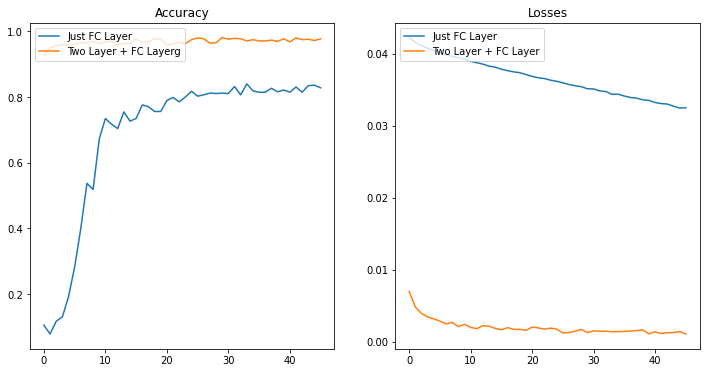

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))


x = range(len(data_resnet18["valid_accuracys"]))
y1 = data_resnet18_two["valid_accuracys"][:len(data_resnet18["valid_accuracys"])]
y2 = data_resnet18["valid_accuracys"][:len(data_resnet18["valid_accuracys"])]

ax[0].plot(x, y1, label="Just FC Layer")
ax[0].plot(x, y2, label="Two Layer + FC Layerg")
ax[0].legend(loc="upper left")
ax[0].set_title("Accuracy")

x = range(len(data_resnet18["valid_losses"]))
y1 = data_resnet18_two["valid_losses"][:len(data_resnet18["valid_losses"])]
y2 = data_resnet18["valid_losses"][:len(data_resnet18["valid_losses"])]

ax[1].plot(x, y1, label="Just FC Layer")
ax[1].plot(x, y2, label="Two Layer + FC Layer")
ax[1].legend(loc="upper left")
ax[1].set_title("Losses")

plt.show()

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

correct = 0
total = 0

y_pred = list()
y_test = list()

with torch.no_grad():
    for (x, y) in tqdm(test_loader, desc="Testing", leave=False):
        images = x.to(device)
        labels = y.to(device)
        outputs = model_resnet18(images)
        _, predictions = torch.max(outputs, 1)
        y_pred = y_pred + predictions.tolist()
        y_test = y_test + labels.tolist()

Testing:   0%|          | 0/12 [00:00<?, ?it/s]

In Part 1, the "Bean" class was not classified well enough. Here we see that we have improved it. A stronger model should be prepared for the "Radish, Tomato" classes.

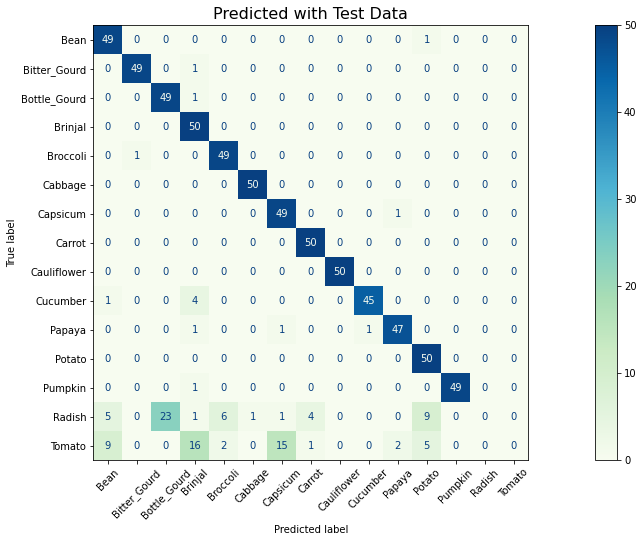

In [69]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax1 = plt.subplots(1, 1, figsize = (24, 8))
disp.plot(ax=ax1, cmap='GnBu')
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_title('Predicted with Test Data', fontsize=16)

plt.show()

# 5 - Conclusion <a name='5'></a>

In all these analyses, the CNN architecture was examined in depth. There are used models that are coded from scratch and pre-trained. Learning rate, epoch, batch size, dropout technique, residual links are analyzed and results are given. Judging by the overall results, it can be said that using pre-trained models is the best option.

All this work was done primarily on Colab using CPU. In this process, determining the correct hyperparameters and training the model required a lot of time. Later, GPU was used on Colab Pro. Even in this process, when we consider an epoch time and the number of models, the epoch number is 50. It has been determined that increasing the number of epochs will increase the success, but will make it difficult in terms of time.

# 6 - References <a name='6'></a>
[PyTorch - Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

[Build an Image Classification Model using Convolutional Neural Networks in PyTorch](https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/)